**Kernel**
- [Porto Seguro Exploratory Analysis and Prediction](https://www.kaggle.com/gpreda/porto-seguro-exploratory-analysis-and-prediction)

**Dataset**
- [Porto Seguro’s Safe Driver Prediction](https://www.kaggle.com/c/porto-seguro-safe-driver-prediction)

## Introduction
이 커널은 Porto Seguro competition 의 데이터를 소개하는 것으로 시작합니다. 그런 다음 cross-validation 과 stacking 을 사용하여 몇 개의 예측 모형을 준비하고 실행하여 제출물을 준비합니다.

## Analysis packages

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
# from sklearn.preprocessing import Imputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

pd.set_option('display.max_columns', 100)

import warnings
warnings.filterwarnings('ignore')

##  Load the data

In [48]:
trainset = pd.read_csv('data/train.csv')
testset = pd.read_csv('data/test.csv')

## Few quick observations
- Few **groups** are defined and features that belongs to these groups include patterns in the name (ind, reg, car, calc). The **ind** indicates most probably **individual**, **reg** is probably **registration**, **car** is self-explanatory, **calc** suggests a **calculated** field
- The postfix **bin** is used for **binary** features
- The postfix **cat** to is used for **categorical** features
- Features without the bin or cat indications are real numbers (**continous** values) of integers (**ordinal** values)
- A **missing value** is indicated by **-1**
- The value that is subject of prediction is in the **target** column. This one indicates whether or not a claim was filed for that insured person
- **id** is a data input ordinal number

In [49]:
trainset.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


'cat' 값은 0에서 n 사이의 정수 값인 범주형이고 'bin' 값은 이진수(0 또는 1)임을 확인할 수 있습니다.

In [50]:
print('Train dataset (rows, cols):', trainset.shape,
      '\nTest dataset (rows, cols):', testset.shape)

Train dataset (rows, cols): (595212, 59) 
Test dataset (rows, cols): (892816, 58)


In [51]:
print('Columns in train and not in test dataset:', set(trainset.columns) - set(testset.columns))

Columns in train and not in test dataset: {'target'}


## Introduction of metadata
데이터의 조작을 더 쉽게 하기 위해, 훈련 데이터셋의 변수와 소수의 메타 정보를 연관지을 것입니다. 이렇게 하면 분석, 검사 또는 모델링을 위한 다양한 유형의 형상을 쉽게 선택할 수 있습니다. 우리는 'car', 'ind', 'reg', 'calc' 유형의 특징에 대한 카테고리 필드도 사용하고 있습니다.

사용할 메타데이터:

- use: input, ID, target
- type: nominal, interval, ordinal, binary
- preserve: True or False
- dataType: int, float, char
- category: ind, reg, car, calc

In [52]:
# uses code from https://www.kaggle.com/bertcarremans/data-preparation-exploration

data = []
for feature in trainset.columns:
    # Defining the role
    if feature == 'target':
        use = 'target'
    elif feature == 'id':
        use = 'id'
    else:
        use = 'input'
    
    # Defining the type
    if 'bin' in feature or feature == 'target':
        type = 'binary'
    elif 'cat' in feature or feature == 'id':
        type = 'categorical'
    elif trainset[feature].dtype == 'float64':
        type = 'real'
    elif trainset[feature].dtype == 'int64':
        type = 'integer'
    
    # Initialize preserve to True for all variables except for id
    preserve = True
    if feature == 'id':
        preserve = False
    
    # Defining the data type 
    dtype = trainset[feature].dtype
    
    # Defining the category
    category = 'none'
    if 'ind' in feature:
        category = 'individual'
    elif 'reg' in feature:
        category = 'registration'
    elif 'car' in feature:
        category = 'car'
    elif 'calc' in feature:
        category = 'calculated'
    
    # Creating a Dict that contains all the metadata for the variable
    feature_dictionary = {
        'varname': feature,
        'use': use,
        'type': type,
        'preserve': preserve,
        'dtype': dtype,
        'category': category
    }
    data.append(feature_dictionary)
    
metadata = pd.DataFrame(data, columns=['varname', 'use', 'type', 'preserve', 'dtype', 'category'])
metadata.set_index('varname', inplace=True)
metadata

,use,type,preserve,dtype,category
varname,,,,,
id,id,categorical,False,int64,none
target,target,binary,True,int64,none
ps_ind_01,input,integer,True,int64,individual
ps_ind_02_cat,input,categorical,True,int64,individual
ps_ind_03,input,integer,True,int64,individual
ps_ind_04_cat,input,categorical,True,int64,individual
ps_ind_05_cat,input,categorical,True,int64,individual
ps_ind_06_bin,input,binary,True,int64,individual
ps_ind_07_bin,input,binary,True,int64,individual


예를 들어 모든 범주형 값을 추출할 수 있습니다.

In [53]:
metadata[(metadata.type == 'categorical') & (metadata.preserve)].index

Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat',
       'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_10_cat', 'ps_car_11_cat'],
      dtype='object', name='varname')

In [54]:
pd.DataFrame({'count': metadata.groupby(['category'])['category'].size()}).reset_index()

,category,count
0,calculated,20
1,car,16
2,individual,18
3,none,2
4,registration,3


In [55]:
pd.DataFrame({'count': metadata.groupby(['use', 'type'])['use'].size()}).reset_index()

,use,type,count
0,id,categorical,1
1,input,binary,17
2,input,categorical,14
3,input,integer,16
4,input,real,10
5,target,binary,1


## Data analysis and statistics

### Target variable

<Figure size 432x288 with 0 Axes>

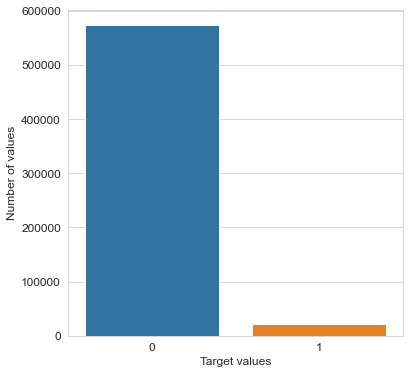

In [56]:
plt.figure()
fig, ax = plt.subplots(figsize=(6,6))
x = trainset['target'].value_counts().index.values
y = trainset['target'].value_counts().values
# Bar plot
# Order the bars descending on target mean
sns.barplot(ax=ax, x=x, y=y)
plt.ylabel('Number of values', fontsize=12)
plt.xlabel('Target values', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

target data 의 3.64%만 1의 값을 가집니다. 이는 훈련 데이터 세트가 불균형하다는 것을 의미합니다. target = 0 으로 레코드를 언더샘플링하거나 target = 1로 오버샘플링할 수 있습니다. 큰 데이터 집합이므로 target = 0 으로 레코드 언더샘플링을 수행합니다.

### Real features

In [57]:
variable = metadata[(metadata.type == 'real') & (metadata.preserve)].index
trainset[variable].describe()

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.610991,0.439184,0.551102,0.379945,0.813265,0.276256,3.065899,0.449756,0.449589,0.449849
std,0.287643,0.404264,0.793506,0.058327,0.224588,0.357154,0.731366,0.287198,0.286893,0.287153
min,0.000000,0.000000,-1.000000,-1.000000,0.250619,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,0.200000,0.525000,0.316228,0.670867,0.333167,2.828427,0.200000,0.200000,0.200000
50%,0.700000,0.300000,0.720677,0.374166,0.765811,0.368782,3.316625,0.500000,0.400000,0.500000
75%,0.900000,0.600000,1.000000,0.400000,0.906190,0.396485,3.605551,0.700000,0.700000,0.700000
max,0.900000,1.800000,4.037945,1.264911,3.720626,0.636396,3.741657,0.900000,0.900000,0.900000


In [58]:
(pow(trainset['ps_car_12'] * 10, 2)).head(10)

0    16.00
1    10.00
2    10.00
3    14.00
4     9.99
5    19.89
6    10.00
7    19.98
8    16.00
9    20.00
Name: ps_car_12, dtype: float64

In [59]:
(pow(trainset['ps_car_15'], 2)).head(10)

0    13.0
1     6.0
2    11.0
3     4.0
4     4.0
5     9.0
6    10.0
7    11.0
8     8.0
9    13.0
Name: ps_car_15, dtype: float64

#### Features with missing values
ps_reg_03, ps_car_12, ps_car_14 에 결측값이 있습니다(최소값이 -1)

#### Registration features
ps_reg_01 및 ps_reg_02 는 분모가 10인 분수(0.1, 0.2, 0.3의 값)입니다.

#### Car features
ps_car_12는 자연수의 제곱근(10으로 나눈)이며 ps_car_15는 자연수의 제곱근이다.

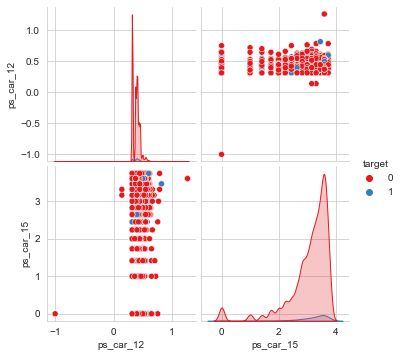

In [60]:
sample = trainset.sample(frac=0.05)
var = ['ps_car_12', 'ps_car_15', 'target']
sample = sample[var]
sns.pairplot(sample, hue='target', palette='Set1', diag_kind='kde')
plt.show()

#### Calculated features
ps_calc_01, ps_calc_02 및 ps_calc_03 은 분포가 매우 유사하며 최대값은 모두 0.9이기 때문에 일종의 비율일 수 있습니다. 계산된 다른 값은 최대값인 정수 값(5,6,7,10,12)을 가집니다.

<Figure size 432x288 with 0 Axes>

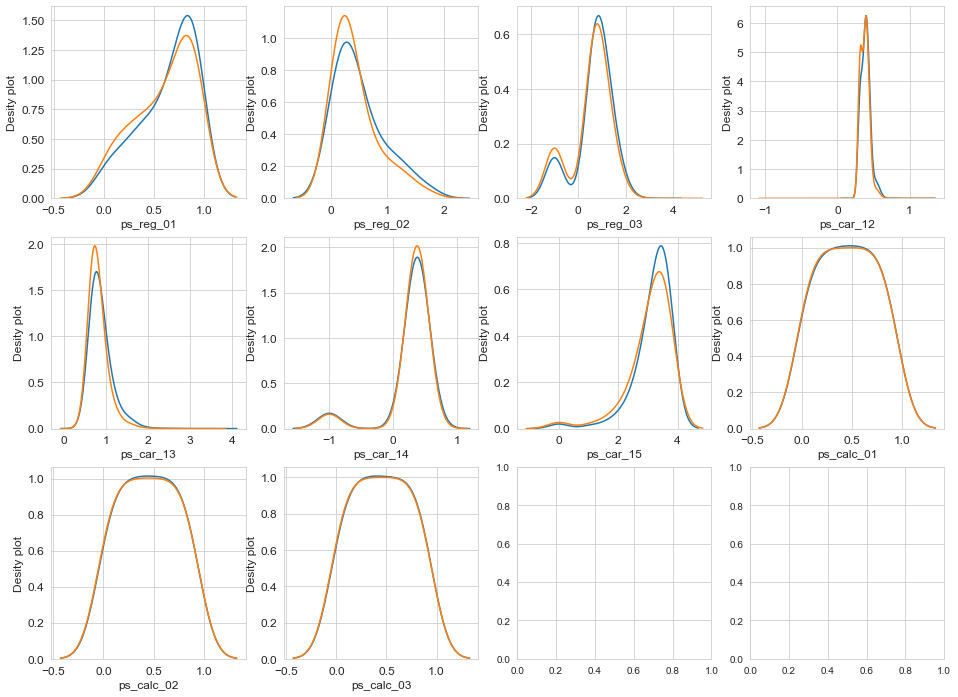

In [61]:
var = metadata[(metadata.type == 'real') & (metadata.preserve)].index

i = 0
t1 = trainset.loc[trainset['target'] != 0]
t0 = trainset.loc[trainset['target'] == 0]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(3, 4, figsize=(16,12))

for feature in var:
    i += 1
    plt.subplot(3, 4, i)
    sns.kdeplot(t1[feature], bw=0.5, label='target = 1')
    sns.kdeplot(t0[feature], bw=0.5, label='target = 0')
    plt.ylabel('Desity plot', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

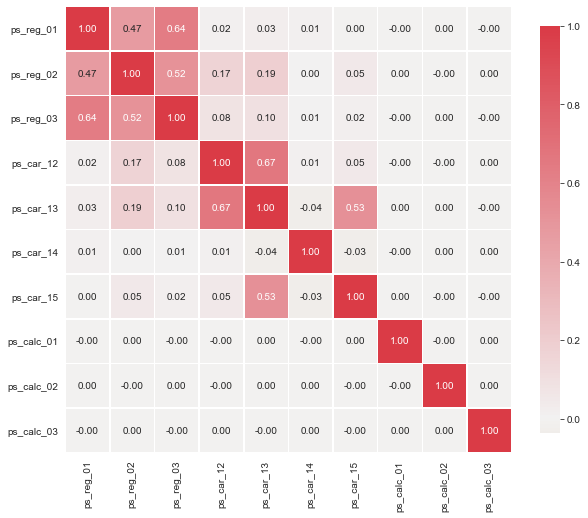

In [62]:
def corr_heatmap(var):
    correlations = trainset[var].corr()
    
    # Create color map ranging betwwen two colors
    cmap = sns.diverging_palette(50, 10, as_cmap=True)
    
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, cmap=cmap, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={'shrink': .75})
    plt.show();
    
var = metadata[(metadata.type == 'real') & (metadata.preserve)].index
corr_heatmap(var)

상관 관계가 강한 변수들

- ps_reg_01 with ps_reg_02 (0.47);
- ps_reg_01 with ps_reg_03 (0.64);
- ps_reg_02 with ps_reg_03 (0.52);
- ps_car_12 with ps_car_13 (0.67);
- ps_car_13 with ps_car_15 (0.53);

상관 관계가 있는 값 쌍을 표시하기 위해 pairplot 을 사용합니다. 쌍을 나타내기 전에 표본에서 2%만 사용하여 데이터를 하위 샘플링합니다.

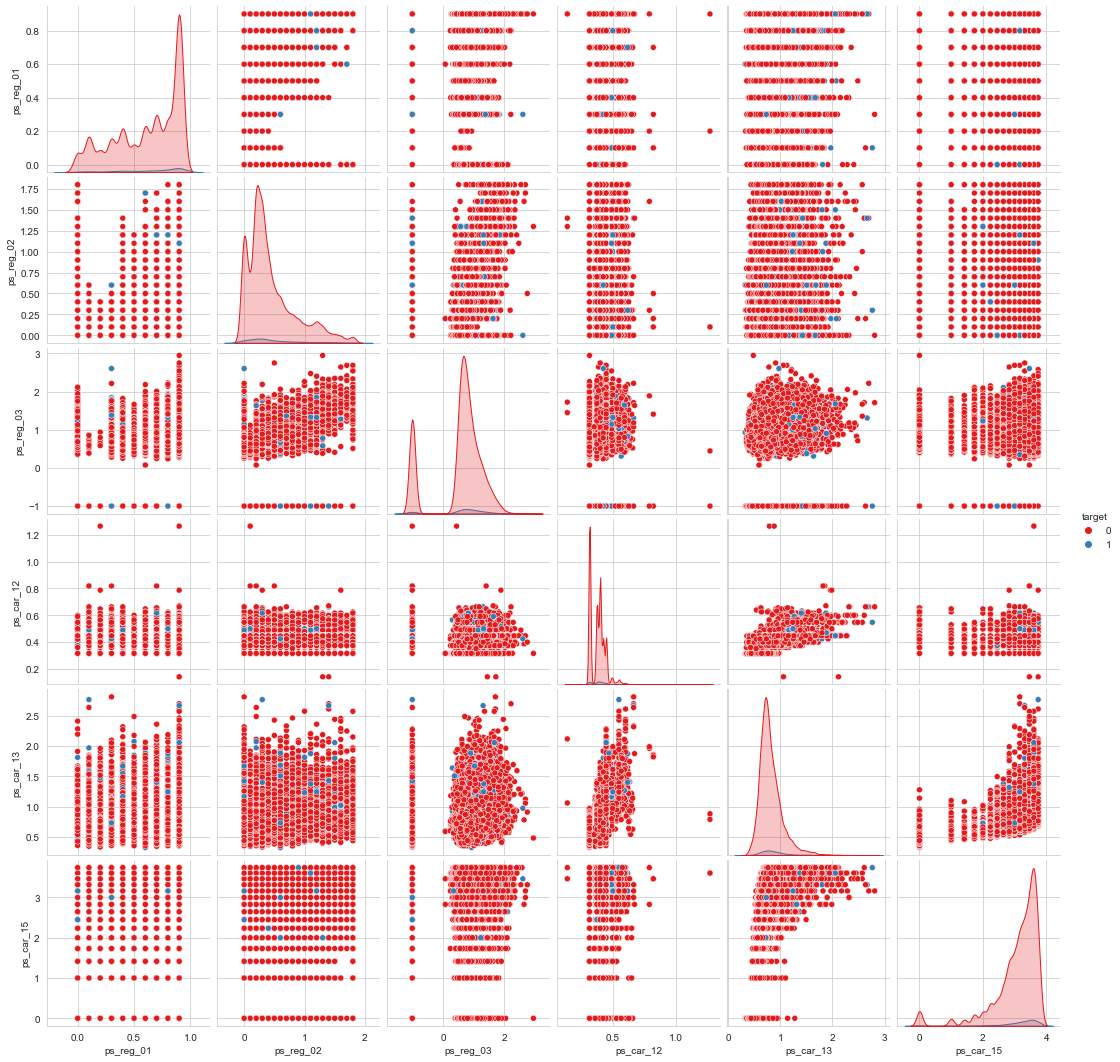

In [63]:
sample = trainset.sample(frac=0.05)
var = ['ps_reg_01', 'ps_reg_02', 'ps_reg_03', 'ps_car_12', 'ps_car_13', 'ps_car_15', 'target']
sample = sample[var]
sns.pairplot(sample, hue='target', palette='Set1', diag_kind='kde')
plt.show()

### Binary features

In [64]:
v = metadata[(metadata.type == 'binary') & (metadata.preserve)].index
trainset[v].describe()

,target,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,0.393742,0.257033,0.163921,0.185304,0.000373,0.001692,0.009439,0.000948,0.660823,0.121081,0.153446,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,0.488579,0.436998,0.370205,0.388544,0.019309,0.041097,0.096693,0.030768,0.473430,0.326222,0.360417,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


훈련 데이터 세트에 binary 데이터의 분포를 표시해보겠습니다. 파란색은 0의 백분율이고 빨간색은 1의 백분율입니다.

<Figure size 432x288 with 0 Axes>

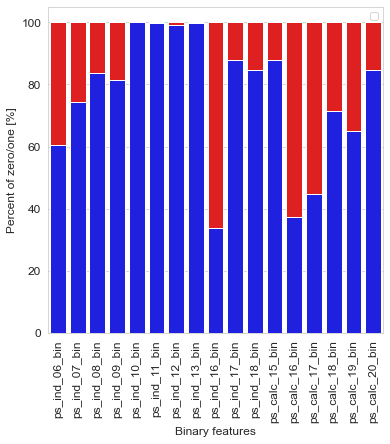

In [65]:
bin_col = [col for col in trainset.columns if '_bin' in col]
zero_list = []
one_list = []

for col in bin_col:
    zero_list.append((trainset[col]==0).sum() / trainset.shape[0]*100)
    one_list.append((trainset[col]==1).sum() / trainset.shape[0]*100)

plt.figure()
fig, ax = plt.subplots(figsize=(6,6))
p1 = sns.barplot(ax=ax, x=bin_col, y=zero_list, color='blue')
p2 = sns.barplot(ax=ax, x=bin_col, y=one_list, bottom=zero_list, color='red')
plt.ylabel('Percent of zero/one [%]', fontsize=12)
plt.xlabel('Binary features', fontsize=12)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend((p1, p2), ('Zero', 'One'))
plt.show()

ps_ind_10_bin, ps_ind_11_bin, ps_ind_12_bin, ps_ind_13_bin 은 값 1의 수가 매우 적은 반면 ps_ind_16_bin, ps_cals_16_bin(60% 이상)은 1의 수가 매우 큽니다.

이제 binary 데이터의 분포와 target 변수의 해당 값을 살펴보겠습니다.

<Figure size 432x288 with 0 Axes>

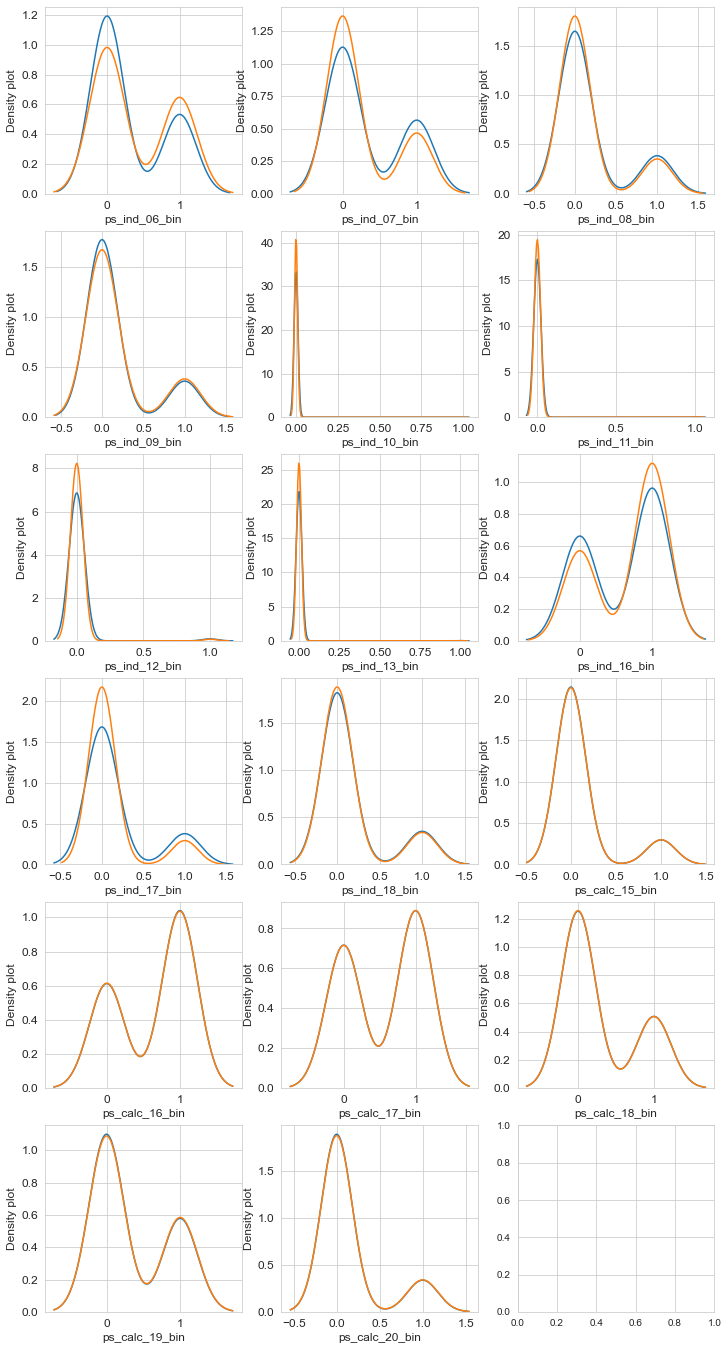

In [66]:
var = metadata[(metadata.type == 'binary') & (metadata.preserve)].index
var = [col for col in trainset.columns if '_bin' in col]

i = 0
t1 = trainset.loc[trainset['target'] != 0]
t0 = trainset.loc[trainset['target'] == 0]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(6, 3, figsize=(12,24))

for feature in var:
    i += 1
    plt.subplot(6, 3, i)
    sns.kdeplot(t1[feature], bw=0.5, label='target = 1')
    sns.kdeplot(t0[feature], bw=0.5, label='target = 0')
    plt.ylabel('Density plot', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

ps_ind_06_bin, ps_ind_07_bin, ps_ind_16_bin, ps_ind_17_bin은 목표값 1과 0 분포 간에 높은 균형을 보입니다.

ps_ind_08_bin은 위의 피처들과 다르게 작은 균형을 보이지만 유사한 밀도 플롯을 나타낸다.

### Categorical features

두 가지 방법으로 범주형 데이터에 대한 분포를 나타낼 것입니다. 먼저 카테고리 값당 target=1 인 백분율을 계산하고 막대 그림을 사용하여 이러한 백분율을 나타냅니다.

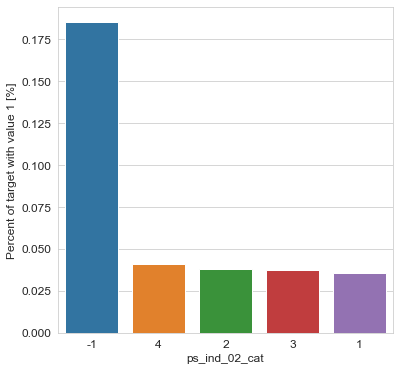

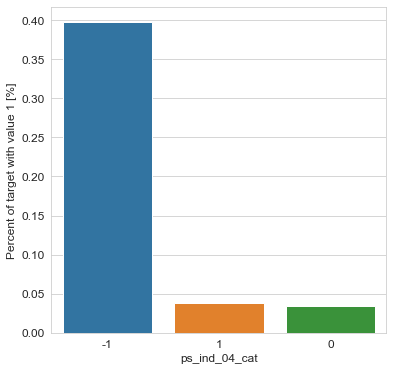

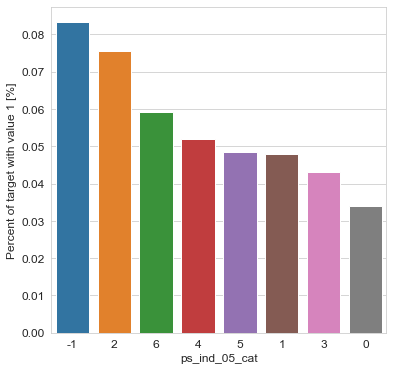

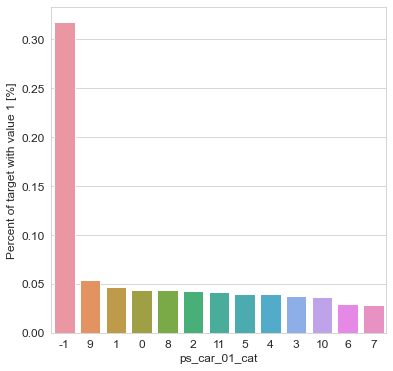

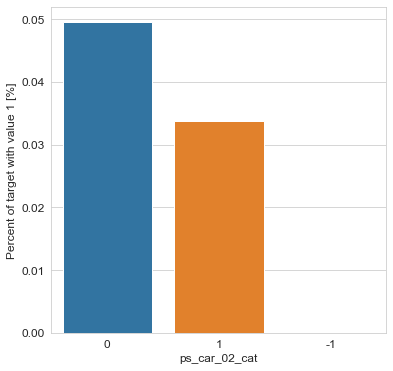

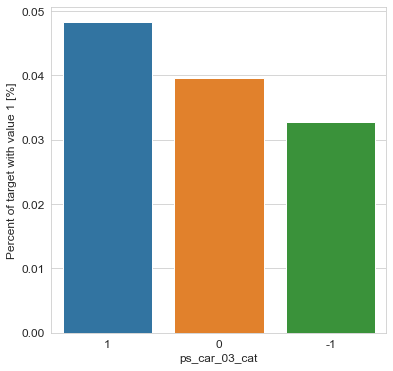

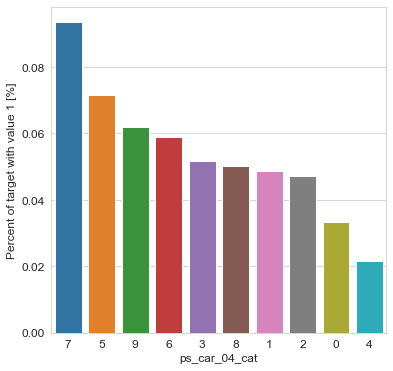

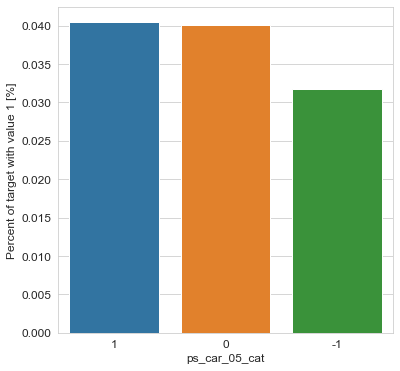

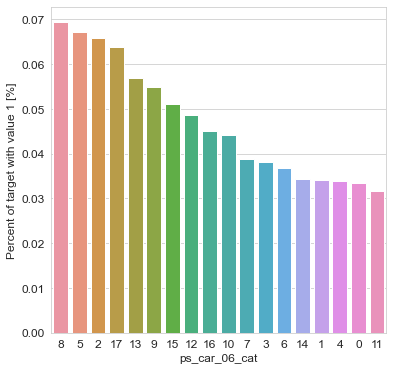

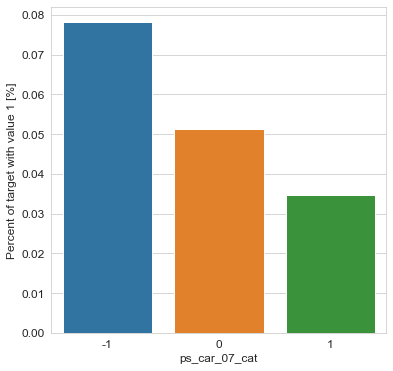

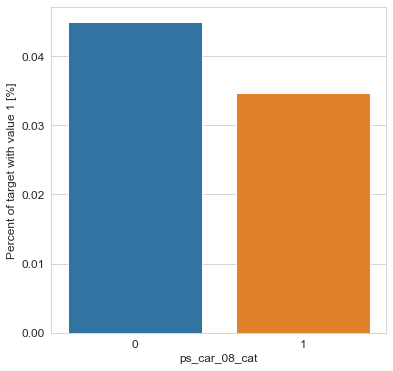

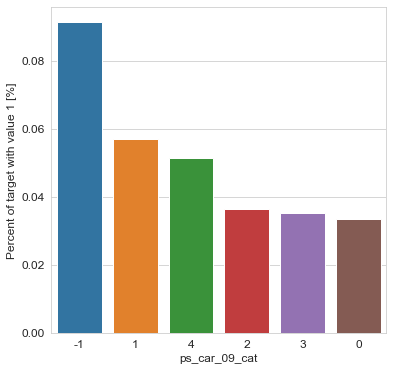

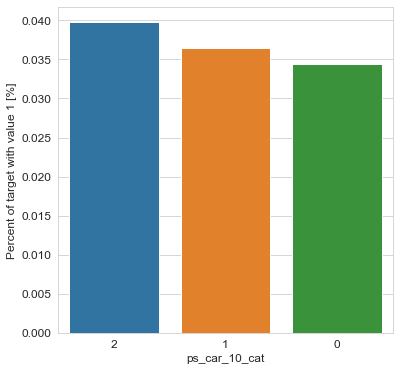

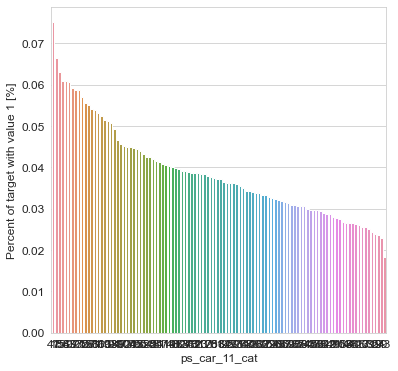

In [67]:
var = metadata[(metadata.type == 'categorical') & (metadata.preserve)].index

for feature in var:
    fig, ax = plt.subplots(figsize=(6, 6))
    
    # Calculate the percentage of target=1 per category value
    cat_perc = trainset[[feature, 'target']].groupby([feature], as_index=False).mean()
    cat_perc.sort_values(by='target', ascending=False, inplace=True)
    
    # Order the bars descending on target mean
    sns.barplot(ax=ax, x=feature, y='target', data=cat_perc, order=cat_perc[feature])
    plt.ylabel('Percent of target with value 1 [%]', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.show()

<Figure size 432x288 with 0 Axes>

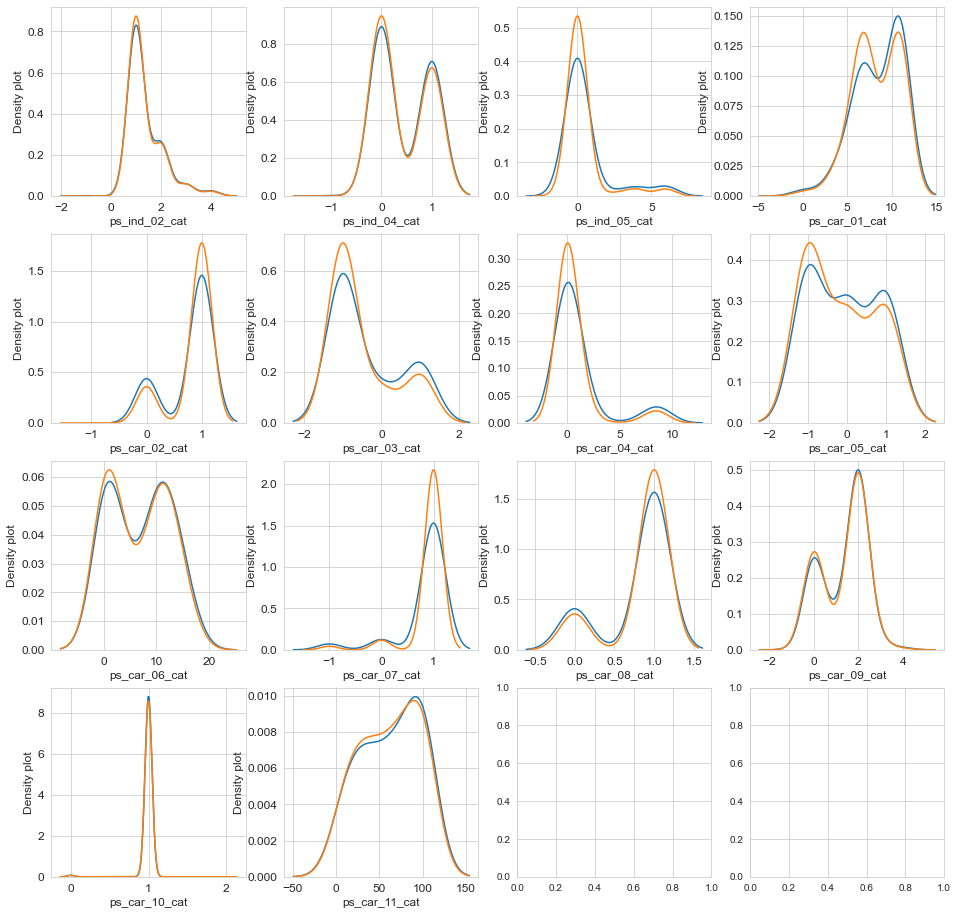

In [68]:
var = metadata[(metadata.type == 'categorical') & (metadata.preserve)].index

i = 0
t1 = trainset.loc[trainset['target'] != 0]
t0 = trainset.loc[trainset['target'] == 0]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(4, 4, figsize=(16,16))

for feature in var:
    i += 1
    plt.subplot(4, 4, i)
    sns.kdeplot(t1[feature], bw=0.5, label='target = 1')
    sns.kdeplot(t0[feature], bw=0.5, label='target = 0')
    plt.ylabel('Density plot', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

### Data unbalance between train and test data

- reg(registration) 피쳐의 train, test 데이터 분포 확인

<Figure size 432x288 with 0 Axes>

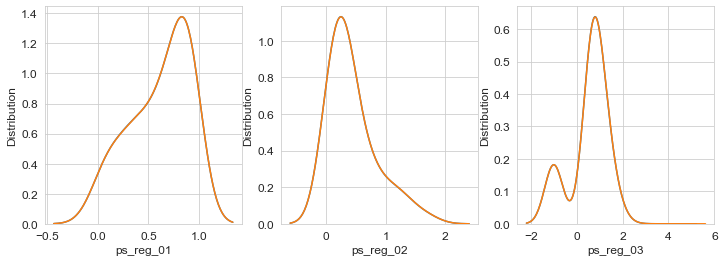

In [69]:
var = metadata[(metadata.category == 'registration') & (metadata.preserve)].index

sns.set_style('whitegrid')

plt.figure()
fig, ax = plt.subplots(1, 3, figsize=(12,4))
i = 0

for feature in var:
    i = i + 1
    plt.subplot(1, 3, i)
    sns.kdeplot(trainset[feature], bw=0.5, label='train')
    sns.kdeplot(testset[feature], bw=0.5, label='test')
    plt.ylabel('Distribution', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    # plt.setp(labels, rotation=90)
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

- car 피쳐의 train, test 데이터 분포 확인

<Figure size 432x288 with 0 Axes>

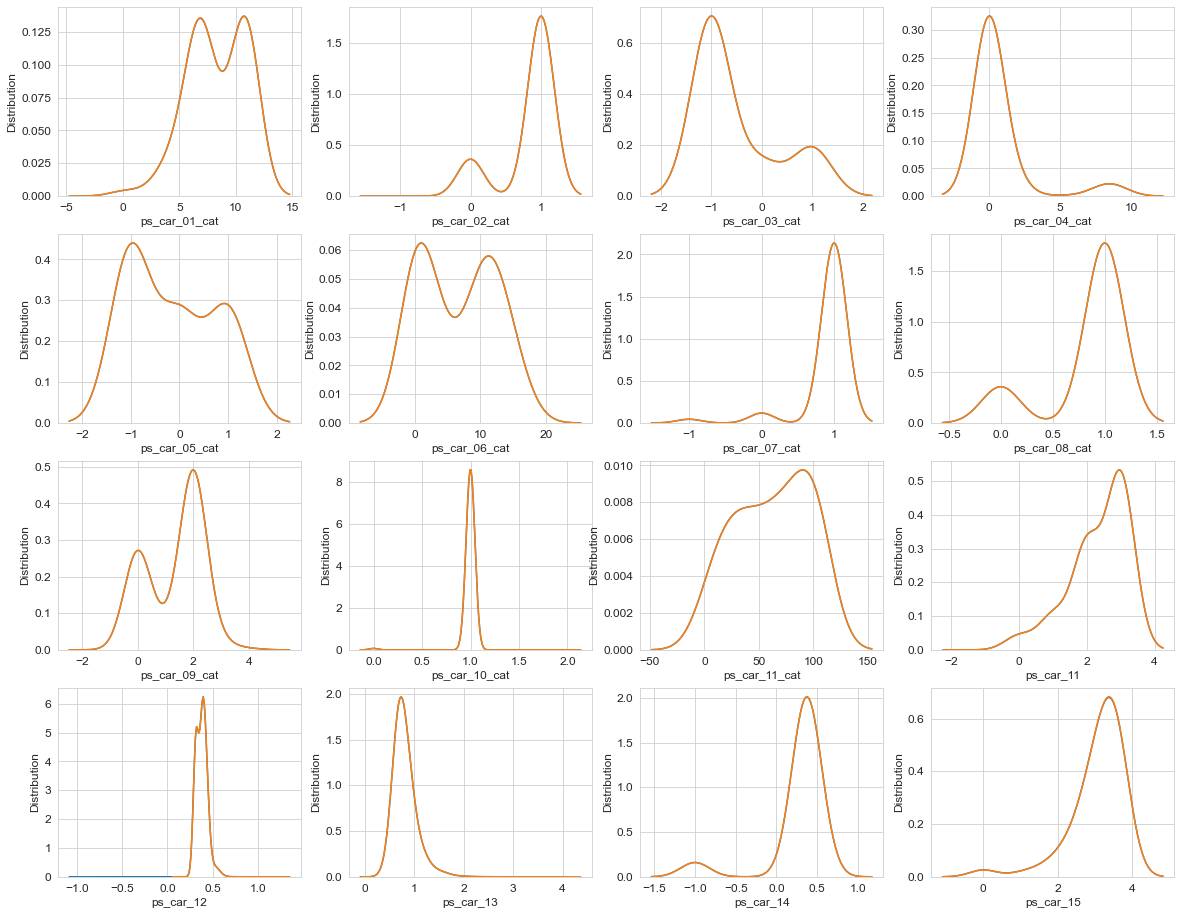

In [70]:
var = metadata[(metadata.category == 'car') & (metadata.preserve)].index

sns.set_style('whitegrid')

plt.figure()
fig, ax = plt.subplots(4, 4, figsize=(20,16))
i = 0

for feature in var:
    i = i + 1
    plt.subplot(4, 4, i)
    sns.kdeplot(trainset[feature], bw=0.5, label='train')
    sns.kdeplot(testset[feature], bw=0.5, label='test')
    plt.ylabel('Distribution', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    # plt.setp(labels, rotation=90)
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

- ind(individual) 피쳐의 train, test 데이터 분포 확인

<Figure size 432x288 with 0 Axes>

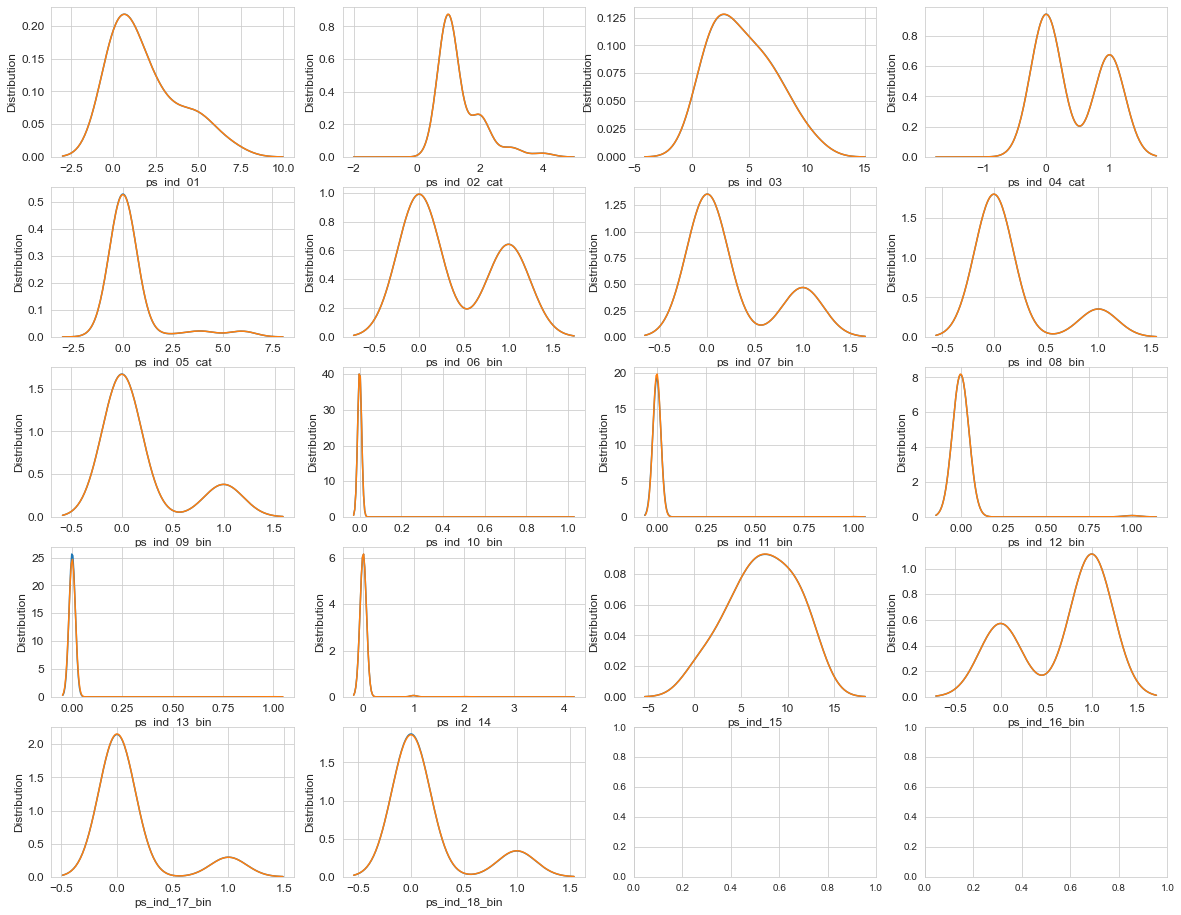

In [71]:
var = metadata[(metadata.category == 'individual') & (metadata.preserve)].index

sns.set_style('whitegrid')

plt.figure()
fig, ax = plt.subplots(5, 4, figsize=(20,16))
i = 0

for feature in var:
    i = i + 1
    plt.subplot(5, 4, i)
    sns.kdeplot(trainset[feature], bw=0.5, label='train')
    sns.kdeplot(testset[feature], bw=0.5, label='test')
    plt.ylabel('Distribution', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    # plt.setp(labels, rotation=90)
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

- calc(calculated) 피쳐의 train, test 데이터 분포 확인

<Figure size 432x288 with 0 Axes>

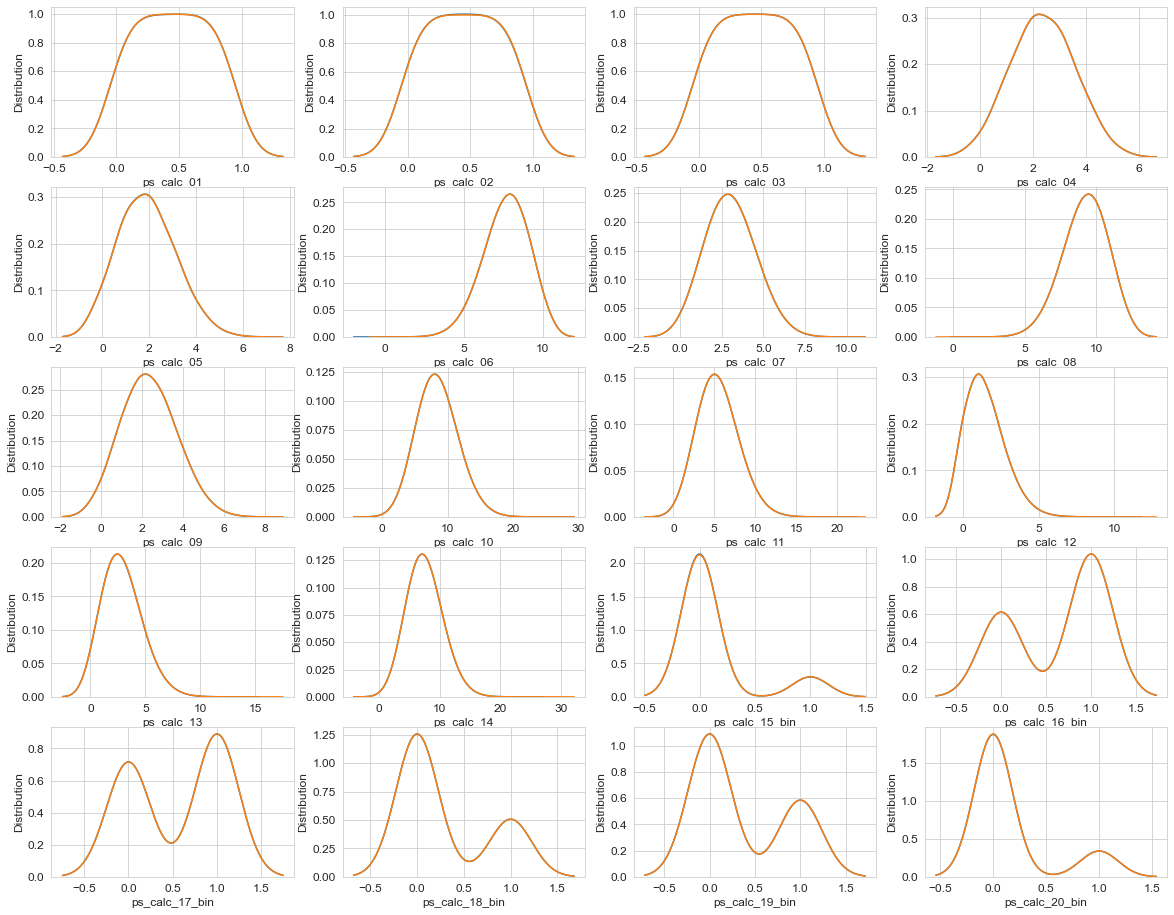

In [72]:
var = metadata[(metadata.category == 'calculated') & (metadata.preserve)].index

sns.set_style('whitegrid')

plt.figure()
fig, ax = plt.subplots(5, 4, figsize=(20,16))
i = 0

for feature in var:
    i = i + 1
    plt.subplot(5, 4, i)
    sns.kdeplot(trainset[feature], bw=0.5, label='train')
    sns.kdeplot(testset[feature], bw=0.5, label='test')
    plt.ylabel('Distribution', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    # plt.setp(labels, rotation=90)
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

## Check data quality

In [73]:
vars_with_missing = []

for feature in trainset.columns:
    missings = trainset[trainset[feature] == -1][feature].count()
    if missings > 0:
        vars_with_missing.append(feature)
        missings_perc = missings / trainset.shape[0]
        
        print(f'Variable {feature} has {missings} records ({missings_perc:.2%}) with missing values')
        
print(f'In total, there are {len(vars_with_missing)} variables with missing values')

Variable ps_ind_02_cat has 216 records (0.04%) with missing values
Variable ps_ind_04_cat has 83 records (0.01%) with missing values
Variable ps_ind_05_cat has 5809 records (0.98%) with missing values
Variable ps_reg_03 has 107772 records (18.11%) with missing values
Variable ps_car_01_cat has 107 records (0.02%) with missing values
Variable ps_car_02_cat has 5 records (0.00%) with missing values
Variable ps_car_03_cat has 411231 records (69.09%) with missing values
Variable ps_car_05_cat has 266551 records (44.78%) with missing values
Variable ps_car_07_cat has 11489 records (1.93%) with missing values
Variable ps_car_09_cat has 569 records (0.10%) with missing values
Variable ps_car_11 has 5 records (0.00%) with missing values
Variable ps_car_12 has 1 records (0.00%) with missing values
Variable ps_car_14 has 42620 records (7.16%) with missing values
In total, there are 13 variables with missing values


## Prepare the data for model

### Drop calc columns

In [74]:
col_to_drop = trainset.columns[trainset.columns.str.startswith('ps_calc_')]
trainset = trainset.drop(col_to_drop, axis=1)
testset = testset.drop(col_to_drop, axis=1)

### Drop variables with too many missing values

In [75]:
vars_to_drop = ['ps_car_03_cat', 'ps_car_05_cat']
trainset.drop(vars_to_drop, inplace=True, axis=1)
testset.drop(vars_to_drop, inplace=True, axis=1)
metadata.loc[(vars_to_drop), 'keep'] = False

In [76]:
# Script by https://www.kaggle.com/ogrellier
# Code: https://www.kaggle.com/ogrellier/python-target-encoding-for-categorical-features

def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

def target_encode(trn_series=None,
                  tst_series=None,
                  target=None,
                  min_samples_leaf=1,
                  smoothing=1,
                  noise_level=0):
    '''
    trn_series : training categorical feature as a pd.Series
    tst_series : test categorical feature as a pd.Series
    target : target data as a pd.Series
    min_samples_leaf (int) : minimum samples to take category average into account
    smoothing (int) : smoothing effect to balance categorical average vs prior  
    '''
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    
    # Compute target mean 
    averages = temp.groupby(by=trn_series.name)[target.name].agg(['mean', 'count'])
    
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages['count'] - min_samples_leaf) / smoothing))
    
    # Apply average function to all target data
    prior = target.mean()
    
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages['mean'] * smoothing
    averages.drop(['mean', 'count'], axis=1, inplace=True)
    
    # Apply averages to trn series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on = trn_series.name,
        how = 'left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index
    
    # Apply averages to tst series
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on = tst_series.name,
        how = 'left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    
    # pd.merge does not keep the index so restore it
    ft_tst_series.index = tst_series.index
    
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

### Replace ps_car_11_cat with encoded value
target_encode 함수를 사용하여 ps_car_11_cat을 train 및 test 데이터 세트에 인코딩된 값으로 교체합니다.

In [77]:
train_encoded, test_encoded = target_encode(
    trainset['ps_car_11_cat'],
    testset['ps_car_11_cat'],
    target=trainset.target,
    min_samples_leaf=100,
    smoothing=10,
    noise_level=0.01)

trainset['ps_car_11_cat_te'] = train_encoded
trainset.drop('ps_car_11_cat', axis=1, inplace=True)
metadata.loc['ps_car_11_cat', 'keep'] = False
testset['ps_car_11_cat_te'] = test_encoded
testset.drop('ps_car_11_cat', axis=1, inplace=True)

### Balance target variable
대상 변수가 매우 불균형합니다. 이는 target = 0 인 언더샘플링 값 또는 target = 1 인 오버샘플링 값으로 개선할 수 있습니다. train 데이터 세트가 다소 크기 때문에 언더샘플링을 선택합니다.

In [78]:
desired_apriori = 0.10

# Get the indices per target value
idx_0 = trainset[trainset.target == 0].index
idx_1 = trainset[trainset.target == 1].index

# Get original number of records per target value
nb_0 = len(trainset.loc[idx_0])
nb_1 = len(trainset.loc[idx_1])

# Calculate the undersampling rate and resulting number of records with target=0
undersampling_rate = ((1-desired_apriori)*nb_1) / (nb_0*desired_apriori)
undersampled_nb_0 = int(undersampling_rate*nb_0)
print(f'Rate to undersample records with target=0: {undersampling_rate}')
print(f'Number of records with target=0 after undersampling: {undersampled_nb_0}')

# Randomly select records with target=0 to get at the desired a priori
undersampled_idx = shuffle(idx_0, random_state=314, n_samples=undersampled_nb_0)

# Construct list with remaining indices
idx_list = list(undersampled_idx) + list(idx_1)

# Return undersample data frame
trainset = trainset.loc[idx_list].reset_index(drop=True)

Rate to undersample records with target=0: 0.34043569687437886
Number of records with target=0 after undersampling: 195246


### Replace -1 values with NaN

In [79]:
trainset = trainset.replace(-1, np.nan)
testset = testset.replace(-1, np.nan)

### Dummify cat values
범주형(cat) 피쳐에 대한 더미 변수를 생성하겠습니다.

In [80]:
cat_features = [a for a in trainset.columns if a.endswith('cat')]

for column in cat_features:
    temp = pd.get_dummies(pd.Series(trainset[column]))
    trainset = pd.concat([trainset, temp], axis=1)
    trainset = trainset.drop([column], axis=1)
    
for column in cat_features:
    temp = pd.get_dummies(pd.Series(testset[column]))
    testset = pd.concat([testset, temp], axis=1)
    testset = testset.drop([column], axis=1)

### Drop unused and target columns

In [81]:
id_test = testset['id'].values
target_train = trainset['target'].values

trainset = trainset.drop(['target', 'id'], axis=1)
testset = testset.drop(['id'], axis=1)

In [82]:
print('Train dataset (rows, cols):', trainset.values.shape)
print('Test dataset (rows, cols):', testset.values.shape)

Train dataset (rows, cols): (216940, 91)
Test dataset (rows, cols): (892816, 91)


## Prepare the model

### Ensemble class for cross validation and ensamble

Ensemble 클래스를 준비하여 KFolds 를 통해 데이터를 분할, 모델을 교육하고 결과를 조립합니다.

클래스에는 다음과 같은 4개의 파라미터를 가진 init 메소드가 있습니다.

- self - 초기화 대상
- n_splits - 사용할 교차 검증 분할 수
- stacker - 훈련된 기본 모델에서 예측 결과를 누적하는 데 사용되는 모델
- base_models - 훈련에 사용되는 base model 목록

두 번째 메소드인 fit_predict에는 네 가지 함수가 있습니다.

- 훈련 데이터를 n_splits 개의 fold 로 분할
- 각 fold 에 대해 base model 실행
- 각 모델을 사용하여 예측을 수행
- stacker 를 사용하여 결과 조립

In [83]:
class Ensemble(object):
    def __init__(self, n_splits, stacker, base_models):
        self.n_splits = n_splits
        self.stacker = stacker
        self.base_models = base_models
        
    def fit_predict(self, X, y, T):
        X = np.array(X)
        y = np.array(y)
        T = np.array(T)
        
        folds = list(StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=314).split(X, y))
        
        S_train = np.zeros((X.shape[0], len(self.base_models)))
        S_test = np.zeros((T.shape[0], len(self.base_models)))
        
        for i, clf in enumerate(self.base_models):
            S_test_i = np.zeros((T.shape[0], self.n_splits))
            
            for j, (train_idx, test_idx) in enumerate(folds):
                X_train = X[train_idx]
                y_train = y[train_idx]
                X_holdout = X[test_idx]
                
                print('Base model %d: fit %s model | fold %d ' % (i+1, str(clf).split('(')[0], j+1))
                clf.fit(X_train, y_train)
                cross_score = cross_val_score(clf, X_train, y_train, cv=3, scoring='roc_auc')
                print('cross_score [roc-auc]: %.5f [gini]: %.5f' % (cross_score.mean(), 2 * cross_score.mean() - 1))
                y_pred = clf.predict_proba(X_holdout)[:, 1]
                
                S_train[test_idx, i] = y_pred
                S_test_i[:, j] = clf.predict_proba(T)[:, 1]
                
            S_test[:, i] = S_test_i.mean(axis=1)
            
        results = cross_val_score(self.stacker, S_train, y, cv=3, scoring='roc_auc')
        
        # Calculate gini factor as 2 * AUC - 1
        print('Stacker score [gini]: %.5f' % (2 * results.mean() - 1))
        
        self.stacker.fit(S_train, y)
        res = self.stacker.predict_proba(S_test)[:, 1]
        return res

### Parameters for the base models
base model 의 경우 3개의 LightGBM 모델과 1개의 XGB 모델을 준비합니다.

각 모델은 데이터를 훈련시키는 데 사용됩니다(교차 검증 사용, 3 folds).

In [85]:
# LightGBM params
# lgb_1
lgb_params1 = {}
lgb_params1['learning_rate'] = 0.02
lgb_params1['n_estimators'] = 650
lgb_params1['max_bin'] = 10
lgb_params1['subsample'] = 0.8
lgb_params1['subsample_freq'] = 10
lgb_params1['colsample_bytree'] = 0.8
lgb_params1['min_child_samples'] = 500
lgb_params1['seed'] = 314
lgb_params1['num_threads'] = 4

# lgb_2
lgb_params2 = {}
lgb_params2['n_estimators'] = 1090
lgb_params2['learning_rate'] = 0.02
lgb_params2['colsample_bytree'] = 0.3
lgb_params2['subsample'] = 0.7
lgb_params2['subsample_freq'] = 2
lgb_params2['num_leaves'] = 16
lgb_params2['seed'] = 314
lgb_params2['num_threads'] = 4

# lgb_3
lgb_params3 = {}
lgb_params3['n_estimators'] = 1100
lgb_params3['max_depth'] = 4
lgb_params3['learning_rate'] = 0.02
lgb_params3['seed'] = 314
lgb_params3['num_threads'] = 4

# XGBoost params
xgb_params = {}
xgb_params['objective'] = 'binary:logistic'
xgb_params['learning_rate'] = 0.04
xgb_params['n_estimators'] = 490
xgb_params['max_depth'] = 4
xgb_params['subsample'] = 0.9
xgb_params['colsample_bytree'] = 0.9
xgb_params['min_child_weight'] = 10
xgb_params['num_threads'] = 4

### Initialize the models with the parameters

In [86]:
# Base models
lgb_model1 = LGBMClassifier(**lgb_params1)

lgb_model2 = LGBMClassifier(**lgb_params2)

lgb_model3 = LGBMClassifier(**lgb_params3)

xgb_model = XGBClassifier(**xgb_params)

# Stacking model
log_model = LogisticRegression()

### Initialize the ensambling object

In [87]:
stack = Ensemble(n_splits = 3,
                 stacker = log_model,
                 base_models = (lgb_model1, lgb_model2, lgb_model3, xgb_model))

## Run the predictive models
stack 객체의 fit_predict 를 호출하여 base 모델의 훈련을 실행, 각 모델의 target 예측, stacker 모델을 사용하여 결과를 조합하고, 결과를 출력합니다.

In [88]:
y_prediction = stack.fit_predict(trainset, target_train, testset)

Base model 1: fit LGBMClassifier model | fold 1 
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
cross_score [roc-auc]: 0.63763 [gini]: 0.27526
Base model 1: fit LGBMClassifier model | fold 2 
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
cross_score [roc-auc]: 0.63961 [gini]: 0.27923
Base model 1: fit LGBMClassifier model | fold 3 
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignor

[21:35:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "num_threads" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:35:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
cross_score [roc-auc]: 0.63943 [gini]: 0.27886
Base model 4: fit XGBClassifier model | fold 3 
[21:35:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "num_threads" } might not be used.

  This may not be accurate due to some parameters ar

## Prepare the submission

In [89]:
submission = pd.DataFrame()
submission['id'] = id_test
submission['target'] = y_prediction
submission.to_csv('data/stacked.csv', index=False)